In [20]:
#    Usefull link(s):
#    with a diagram of how to procede with a time series forecasting
#    https://stats.stackexchange.com/questions/380599/is-it-possible-to-automate-time-series-forecasting/380689#380689

In [70]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python, i usually need this somewhere 
                       # and so i import by habit nowadays

import matplotlib.pyplot as plt # for charts and such
import matplotlib.ticker as ticker

import itertools
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import pearsonr


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import kpss
# from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

from pylab import rcParams
import pmdarima as pm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler

# Initialize plotly
init_notebook_mode(connected=True)

from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

import datetime as dt  # for dealing with times
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

In [3]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

In [4]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

In [5]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


In [6]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [7]:
# def perform_metrics(y_truth, y_forecasted): 
    
#     mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
#     mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
#     mse = round(mean_squared_error(y_truth, y_forecasted), 4)
#     rmse = round(mse**(0.5), 4)
#     rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
#     r2 = round(r2_score(y_truth, y_forecasted), 4)
#     corr, _ = pearsonr(y_truth, y_forecasted)
#     pearson = round(corr, 4)
    
# #     print('mae', mae)
# #     print('mape', mape)
# #     print('mse', mse)
# #     print('rmse', rmse)
# #     print('rmspe', rmspe)
# #     print('r2', r2)
# #     print('pearson', pearson)
    
#     return mae, mape, mse, rmse, rmspe, r2, pearson

In [8]:
class ExponentialSmoothing(object):
    
    def __init__(self, df, percentage_train_size, list_alpha, list_beta):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.list_alpha = list_alpha
        self.list_beta = list_beta
            
    def perform(self):
        
        best_params, last_index = self.create_model()
        
        array_pred = np.array([])
        
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred = self.prediction(best_params = best_params, last_index = row[0])
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)

            
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.index[:-last_index], self.df['Close'].values[:-last_index], color="gray")
        ax.plot(self.df.index[-last_index:], self.df['Close'].values[-last_index:], label = 'Close', color="gray")
        ax.plot(self.df.index[-last_index:], self.df.iloc[-last_index:]['Close'].values, color = 'r')
        ax.plot(self.df.index[-last_index:], array_pred.reshape(-1, 1), label="alpha="+str(best_params[0])+", beta="+str(best_params[1]), color = 'r')
        ax.legend()
        plt.show()
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        ax.legend()
        plt.show()
        
        return True
    
    def prediction(self, best_params, last_index):
        
        model = Holt(np.asarray(self.df[:last_index]))
                
        fit_model = model.fit(smoothing_level = best_params[0], smoothing_slope = best_params[1])
        pred = fit_model.forecast( steps = 1)
        
        return pred
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        model = Holt(np.asarray(self.df.iloc[:-last_index]))
        best_aic = np.inf
        best_fit = 0
        
        for alpha in self.list_alpha:
            
            for beta in self.list_beta:
            
                fit_model = model.fit(smoothing_level = alpha, smoothing_slope = beta)
                
                if fit_model.aic < best_aic:
                    best_aic = fit_model.aic
                    best_fit = fit_model
                    best_params = (alpha, beta)
        
        print('AIC', best_aic, 'best_params', best_params)
        
        return best_params, last_index
    
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    



AIC 18487.76890753961 best_params (0.95, 0.0)
last_index 2020-03-09 00:00:00
pred [7945.44419487]
last_index 2020-03-10 00:00:00
pred [7888.97069336]
last_index 2020-03-11 00:00:00
pred [7937.92027058]
last_index 2020-03-12 00:00:00
pred [4988.65302222]
last_index 2020-03-13 00:00:00
pred [5623.14935729]
last_index 2020-03-14 00:00:00
pred [5194.79969454]
last_index 2020-03-15 00:00:00
pred [5339.16186362]
last_index 2020-03-16 00:00:00
pred [5053.69847314]
last_index 2020-03-17 00:00:00
pred [5331.74436739]
last_index 2020-03-18 00:00:00
pred [5419.20420412]
last_index 2020-03-19 00:00:00
pred [6156.08459978]
last_index 2020-03-20 00:00:00
pred [6206.38426111]
last_index 2020-03-21 00:00:00
pred [6212.01092306]
last_index 2020-03-22 00:00:00
pred [5861.5143664]
last_index 2020-03-23 00:00:00
pred [6471.92022054]
last_index 2020-03-24 00:00:00
pred [6764.39371045]
last_index 2020-03-25 00:00:00
pred [6702.16856429]
last_index 2020-03-26 00:00:00
pred [6731.10003856]
last_index 2020-03-

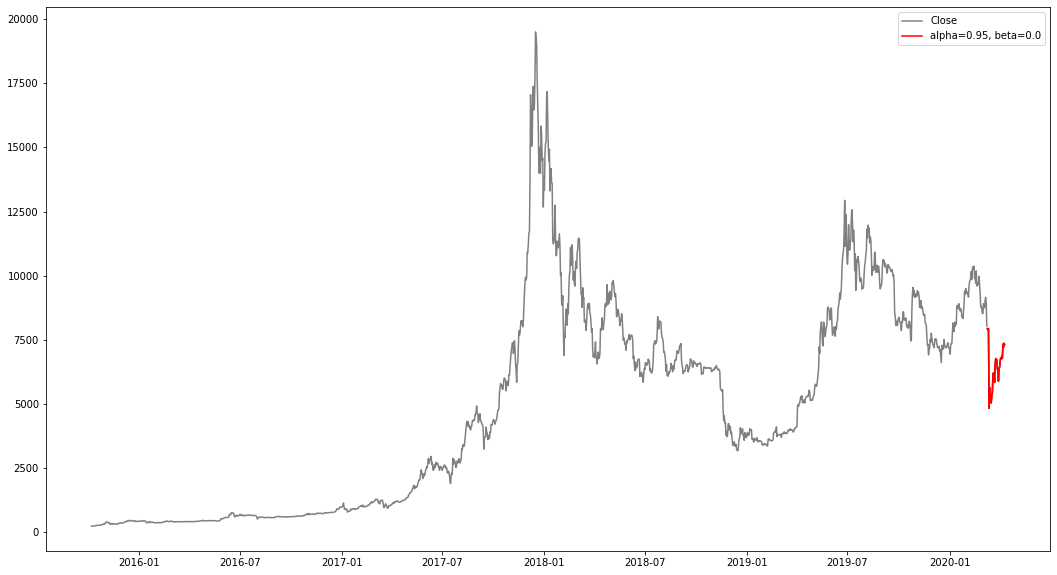

len 32 32
mae 16.6489 mape 0.2908 mse 1013.412 rmse 31.8341 rmspe 0.631 r2 0.9985 pearson 0.9993


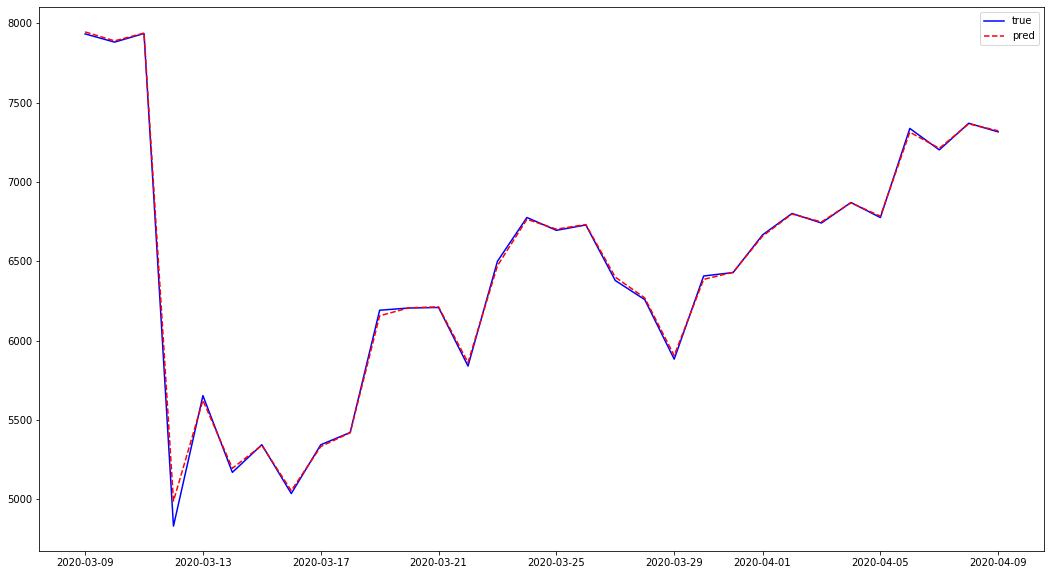

In [26]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
df = df.asfreq('D') # D or H

days = 1
list_alpha = [a/100 for a in range(0, 100, 5)]
list_beta = [b/100 for b in range(0, 100, 5)]
exponential_smoothing = ExponentialSmoothing(df = df,
                                             percentage_train_size = 0.98, 
                                             list_alpha = list_alpha, 
                                             list_beta = list_beta
                                            )
_ = exponential_smoothing.perform()

In [49]:
#diario
# variando 1 ticket 
# mae 4.8521 mape 0.0597 mse 35.0715 rmse 5.9221 rmspe 0.0747 r2 1.0 pears
# AIC 17276.259290836486 best_params (0.99, 0.0)
# 80% treino

#diario
# variando 5 ticket
# mae 12.4462 mape 0.1511 mse 369.8041 rmse 19.2303 rmspe 0.2581 r2 0.9999 pearson 1.0
# AIC 17288.249021280662 best_params (0.95, 0.0)
# 80% treino

#por hora 
#variando 5 ticket
#mae 1.7675 mape 0.023 mse 10.7606 rmse 3.2803 rmspe 0.0485 r2 1.0 pearson 1.0
#AIC 174734.91212908336 best_params (0.95, 0.0)
#80% treino

In [8]:
class ARIMAForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:last_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[last_index:last_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        pq_rng = range(5) # [0,1,2,3]
        d_rng = range(3) # [0,1]
        for p in pq_rng:
            for d in d_rng:
                for q in pq_rng:
                    try:
                        mod = pm.ARIMA(order=(p, d, q))

                        results = mod.fit(self.df.iloc[:last_index])

                        tmp_aic = results.aic()
                        
                        if tmp_aic < best_aic:
                            best_aic = tmp_aic
                            best_order = (p, d, q)
                            best_mdl = mod #não esta sendo utilizado
                            
                    except: continue
        
#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_q = 0, 
#                               start_d = 0, 
#                               max_p = 5,
#                               max_d = 2,
#                               max_q = 5,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 199.86 | order: (0, 1, 2)
             Close
Date              
2020-02-24  9660.0
last_index 2020-02-24 00:00:00
pred 9653.033223662658
             Close
Date              
2020-02-25  9305.0
last_index 2020-02-25 00:00:00
pred 9306.71680036438
             Close
Date              
2020-02-26  8778.3
last_index 2020-02-26 00:00:00
pred 8774.91592258863
              Close
Date               
2020-02-27  8812.49
last_index 2020-02-27 00:00:00
pred 8825.871280507403
              Close
Date               
2020-02-28  8708.89
last_index 2020-02-28 00:00:00
pred 8709.807792770505
              Close
Date               
2020-02-29  8525.07
last_index 2020-02-29 00:00:00
pred 8526.487823567797
              Close
Date               
2020-03-01  8522.31
last_index 2020-03-01 00:00:00
pred 8529.195796732265
             Close
Date              
2020-03-02  8915.0
last_index 2020-03-02 00:00:00
pred 8929.042807201531
              Close
Date               
2020-03-03  8757.84
last_index 

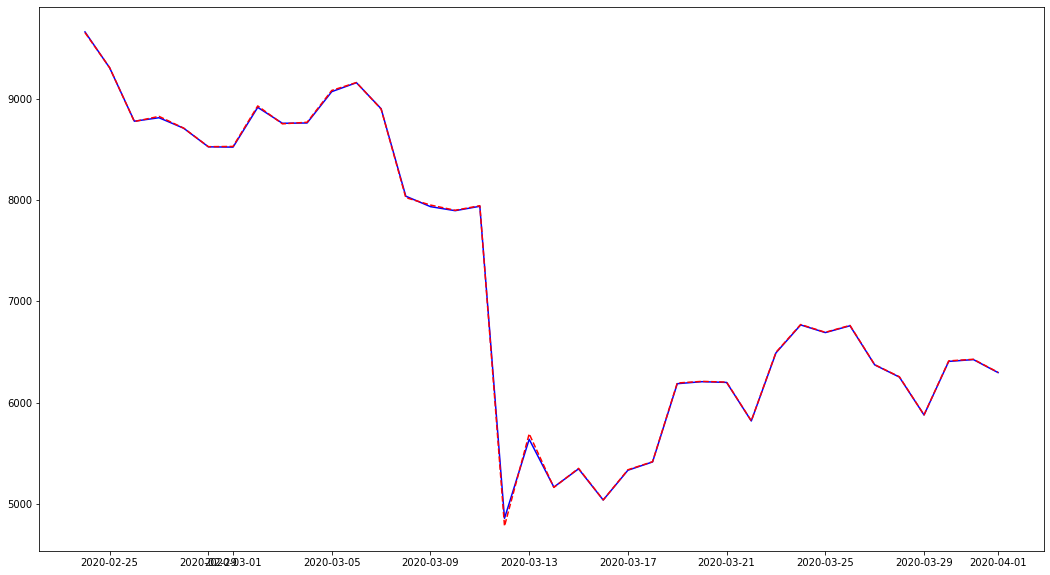

In [27]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
df = df.asfreq('D') # D or H

arima_forecast = ARIMAForecast(df = df, 
                               percentage_train_size = 0.98)
arima_forecast.perform()

In [22]:
# diario
# aic: 21644.13 | order: (1, 1, 1)
# mae 20.9351 mape 0.2591 mse 877.1319 rmse 29.6164 rmspe 0.3744 r2 0.9998 pearson 0.9999
# 80% treino (numero de previssoes: 387) 
# depois de colocar update
# mae 22.3735 mape 0.2792 mse 1009.2598 rmse 31.7688 rmspe 0.406 r2 0.9998 pearson 0.9999

# por hora
# aic: 229438.22 | order: (2, 1, 2)
# mae 2.5702 mape 0.0333 mse 21.1397 rmse 4.5978 rmspe 0.0663 r2 1.0 pearson 1.0
# 80% treino (numero de previssoes: 4824) 

In [34]:
class ProphetForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
        self.fitted_lambda = 0
    
    def perform(self):
        
        
        best_order, last_index = self.create_model()
        print('self.df head', self.df.tail())
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
    
            pred = self.prediction(best_order = best_order, last_index = row[1])
            array_pred = np.append(array_pred, pred)
            print('last_index', row[1])
            print('pred', pred)
        
        print('---')
        print('list_pred', array_pred)
        print('df close', self.df.iloc[-last_index:]['Close'].values)
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(y_truth = y_true, y_forecasted = y_pred)
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:]['Date'], y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:]['Date'], y_pred, color="r", linestyle = '--', label = "pred")
        plt.legend()
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index):
        
        model = Prophet()
        #changepoint_prior_scale=0.5
        
        df_train = self.df[['Date', 'diff_1']]
        df_train.columns = ['ds', 'y']
        df_train = df_train[ df_train['ds'] <= last_index]
        df_train = df_train[ df_train['y'] > 0 ]
        
        model.fit(df_train)
        future = model.make_future_dataframe(periods=1, freq='D')
        
        print('df_fit->\n', df_train.tail(1))
        print('future->\n', future.tail(1))
        
        forecast = model.predict(future)
        
        print('forecast->\n', forecast.iloc[-1][['ds', 'yhat']])
#         print('yhat\n', forecast.iloc[-1]['yhat'])
        
        last_row = self.df[ self.df['Date'] == last_index]
        
        print('last_row->\n', last_row )
        print('self.fitted_lambda->', self.fitted_lambda)
#         pred = last_row['Close'].values[-1] + last_row['diff_1'].values[-1] + forecast.iloc[-1]['yhat']
        pred = last_row['Close_transform'].values[-1] + forecast.iloc[-1]['yhat']
#         pred = last_row['Close_transform'].values[-1] + last_row['diff_1'].values[-1] + forecast.iloc[-1]['yhat']
        print('pred raw->', pred)
        pred = inv_boxcox(pred, self.fitted_lambda)
        
        return pred
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None
        #otimizar treino não implementado
        #yearly_seasonality = False, daily_seasonality = False, weekly_seasonality = False    
        
        self.df['Close_transform'], self.fitted_lambda = boxcox(self.df['Close'], lmbda = None)
        self.df['diff_1'] = self.df['Close_transform'].diff()
        self.df['diff_2'] = self.df['diff_1'].diff()
        
        df_train = self.df[['Date', 'diff_1']]
        df_train.columns = ['ds', 'y']
        
        
        m = Prophet()
        m.fit(df_train[:-last_index])

            
#             tmp_aic = results.aic
#             if tmp_aic < best_aic:
#                 best_aic = tmp_aic
#                 best_order = (i, d, j)
#                 best_mdl = mod #não esta sendo utilizado

#         print('aic: %6.2f | order: %s'%(best_aic, best_order))
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df[:-last_index]['Date'], self.df[:-last_index]['Close_transform'], color="b", label = "Close_transform")
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df[:-last_index]['Date'], self.df[:-last_index]['diff_1'], color="b", label = "diff_1")
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df[:-last_index]['Date'], self.df[:-last_index]['diff_2'], color="b", label = "diff_2")
        plt.legend()
        plt.show()
        
        return None, last_index
    




In [50]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

#df = df.set_index('Date')
df = df[['Date', 'Close']]
df = df.sort_values(by = ['Date']).reset_index(drop = True)

# df = df.asfreq('D') # D or H

prophet_forecast = ProphetForecast(df = df, 
                                    percentage_train_size = 0.98)
prophet_forecast.perform()

#variar os seguintes parametros:
#growth
#changepoints
#n_changepoints
#changepoint_prior_scale

NameError: name 'ProphetForecast' is not defined

In [22]:
df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

#df = df.set_index('Date')
df = df[['Date', 'Close']]
df = df.sort_values(by = ['Date']).reset_index(drop = True)

# df['Close_transform'], fitted_lambda = boxcox(df['Close'], lmbda = None)
# df['diff_1'] = self.df['Close_transform'].diff()
# df['diff_2'] = self.df['diff_1'].diff()

df_train = df[['Date', 'Close']]
df_train.columns = ['ds', 'y']


m = Prophet(changepoint_prior_scale=30)
m.fit(df_train[:-100])
try:
    print('aic', m.aic())
except:
    print('n deu 1')
future = m.make_future_dataframe(periods=1, freq='D')

print('df_fit->\n', df_train[:-100].tail(1))
print('future->\n', future.tail(1))

forecast = m.predict(future)
print('forecast->\n', forecast.iloc[-1][['ds', 'yhat']])
print('real value->\n', df_train[:-99].tail(1))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


n deu 1
df_fit->
              ds       y
1545 2019-12-31  7165.9
future->
              ds
1546 2020-01-01
forecast->
 ds      2020-01-01 00:00:00
yhat                7775.29
Name: 1546, dtype: object
real value->
              ds       y
1546 2020-01-01  7175.2


In [36]:
# com diff 2 e com box cox
# mae 505.525 mape 18.3477 mse 451336.44 rmse 671.8158 rmspe 23.7784 r2 0.3287 pearson None
# com diff 1 e com box cox
# mae 166.824 mape 15.3466 mse 29238.7561 rmse 170.9934 rmspe 19.6215 r2 0.9565 pearson None
# https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
# o link acima mostra como otimizar o prophet

In [125]:
class ARForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:last_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[last_index:last_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        p_rng = range(6)
        d_rng = range(3) # [0,1,2]
        for d in d_rng:
            for p in p_rng:
                try:
                    mod = pm.ARIMA(order=(p, d, 0))

                    results = mod.fit(self.df.iloc[:last_index])

                    tmp_aic = results.aic()
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, 0)
                        best_mdl = mod #não esta sendo utilizado
                except: continue
        
#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_q = 0, 
#                               start_d = 0, 
#                               max_p = 5,
#                               max_d = 2,
#                               max_q = 0,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 3033.27 | order: (4, 1, 0)
              Close
Date               
2019-02-28  3792.14
last_index 2019-02-28 00:00:00
pred 3790.3956972479177
              Close
Date               
2019-03-01  3806.17
last_index 2019-03-01 00:00:00
pred 3810.316152109648
             Close
Date              
2019-03-02  3809.7
last_index 2019-03-02 00:00:00
pred 3811.7326178448916
              Close
Date               
2019-03-03  3786.93
last_index 2019-03-03 00:00:00
pred 3787.780866322245
              Close
Date               
2019-03-04  3700.72
last_index 2019-03-04 00:00:00
pred 3696.884506089793
              Close
Date               
2019-03-05  3844.59
last_index 2019-03-05 00:00:00
pred 3858.9301883048797
              Close
Date               
2019-03-06  3851.89
last_index 2019-03-06 00:00:00
pred 3851.409398426557
              Close
Date               
2019-03-07  3857.05
last_index 2019-03-07 00:00:00
pred 3863.2946384798265
              Close
Date               
2019-03-08  384

             Close
Date              
2019-05-24  8001.7
last_index 2019-05-24 00:00:00
pred 8011.5360756454775
              Close
Date               
2019-05-25  8063.81
last_index 2019-05-25 00:00:00
pred 8078.642166182026
              Close
Date               
2019-05-26  8731.72
last_index 2019-05-26 00:00:00
pred 8771.610258106757
              Close
Date               
2019-05-27  8772.29
last_index 2019-05-27 00:00:00
pred 8762.742712912472
              Close
Date               
2019-05-28  8715.36
last_index 2019-05-28 00:00:00
pred 8712.356737091512
              Close
Date               
2019-05-29  8662.44
last_index 2019-05-29 00:00:00
pred 8644.111084189923
              Close
Date               
2019-05-30  8279.69
last_index 2019-05-30 00:00:00
pred 8258.89711305204
              Close
Date               
2019-05-31  8554.06
last_index 2019-05-31 00:00:00
pred 8586.85767511951
              Close
Date               
2019-06-01  8558.95
last_index 2019-06-01 00:00:00
p

               Close
Date                
2019-08-04  10977.51
last_index 2019-08-04 00:00:00
pred 10969.872176224633
               Close
Date                
2019-08-05  11819.49
last_index 2019-08-05 00:00:00
pred 11845.925976250497
               Close
Date                
2019-08-06  11465.49
last_index 2019-08-06 00:00:00
pred 11438.279732971278
               Close
Date                
2019-08-07  11975.03
last_index 2019-08-07 00:00:00
pred 12007.10281749916
              Close
Date               
2019-08-08  11981.0
last_index 2019-08-08 00:00:00
pred 11937.840528201814
              Close
Date               
2019-08-09  11856.1
last_index 2019-08-09 00:00:00
pred 11884.790343223642
               Close
Date                
2019-08-10  11280.95
last_index 2019-08-10 00:00:00
pred 11254.328357654234
               Close
Date                
2019-08-11  11540.76
last_index 2019-08-11 00:00:00
pred 11559.594420211984
               Close
Date                
2019-08-12  11389.28


             Close
Date              
2019-10-14  8355.0
last_index 2019-10-14 00:00:00
pred 8374.088273569485
              Close
Date               
2019-10-15  8162.44
last_index 2019-10-15 00:00:00
pred 8158.25974605968
              Close
Date               
2019-10-16  7993.54
last_index 2019-10-16 00:00:00
pred 7998.8500521816695
             Close
Date              
2019-10-17  8076.2
last_index 2019-10-17 00:00:00
pred 8079.908383169307
              Close
Date               
2019-10-18  7954.16
last_index 2019-10-18 00:00:00
pred 7957.07337508375
              Close
Date               
2019-10-19  7965.28
last_index 2019-10-19 00:00:00
pred 7979.55271712971
              Close
Date               
2019-10-20  8236.12
last_index 2019-10-20 00:00:00
pred 8242.784179066914
              Close
Date               
2019-10-21  8209.92
last_index 2019-10-21 00:00:00
pred 8213.175718107797
              Close
Date               
2019-10-22  8024.72
last_index 2019-10-22 00:00:00
pred 

              Close
Date               
2019-12-26  7194.13
last_index 2019-12-26 00:00:00
pred 7205.317394647602
              Close
Date               
2019-12-27  7245.83
last_index 2019-12-27 00:00:00
pred 7252.215961702371
              Close
Date               
2019-12-28  7302.67
last_index 2019-12-28 00:00:00
pred 7309.339049214691
              Close
Date               
2019-12-29  7384.89
last_index 2019-12-29 00:00:00
pred 7390.673044033158
             Close
Date              
2019-12-30  7218.0
last_index 2019-12-30 00:00:00
pred 7214.186587482569
              Close
Date               
2019-12-31  7165.72
last_index 2019-12-31 00:00:00
pred 7170.202261565493
              Close
Date               
2020-01-01  7174.33
last_index 2020-01-01 00:00:00
pred 7174.45414361755
              Close
Date               
2020-01-02  6945.02
last_index 2020-01-02 00:00:00
pred 6946.703060014969
              Close
Date               
2020-01-03  7334.45
last_index 2020-01-03 00:00:00
p

              Close
Date               
2020-03-08  8037.76
last_index 2020-03-08 00:00:00
pred 8015.511724382781
              Close
Date               
2020-03-09  7934.52
last_index 2020-03-09 00:00:00
pred 7944.530237220501
              Close
Date               
2020-03-10  7894.68
last_index 2020-03-10 00:00:00
pred 7898.0277615428195
              Close
Date               
2020-03-11  7938.05
last_index 2020-03-11 00:00:00
pred 7968.29637335925
             Close
Date              
2020-03-12  4857.1
last_index 2020-03-12 00:00:00
pred 4781.387391142829
             Close
Date              
2020-03-13  5637.6
last_index 2020-03-13 00:00:00
pred 5691.433298874507
              Close
Date               
2020-03-14  5165.25
last_index 2020-03-14 00:00:00
pred 5128.245968638362
              Close
Date               
2020-03-15  5345.35
last_index 2020-03-15 00:00:00
pred 5390.4323586117935
              Close
Date               
2020-03-16  5037.61
last_index 2020-03-16 00:00:00
pr

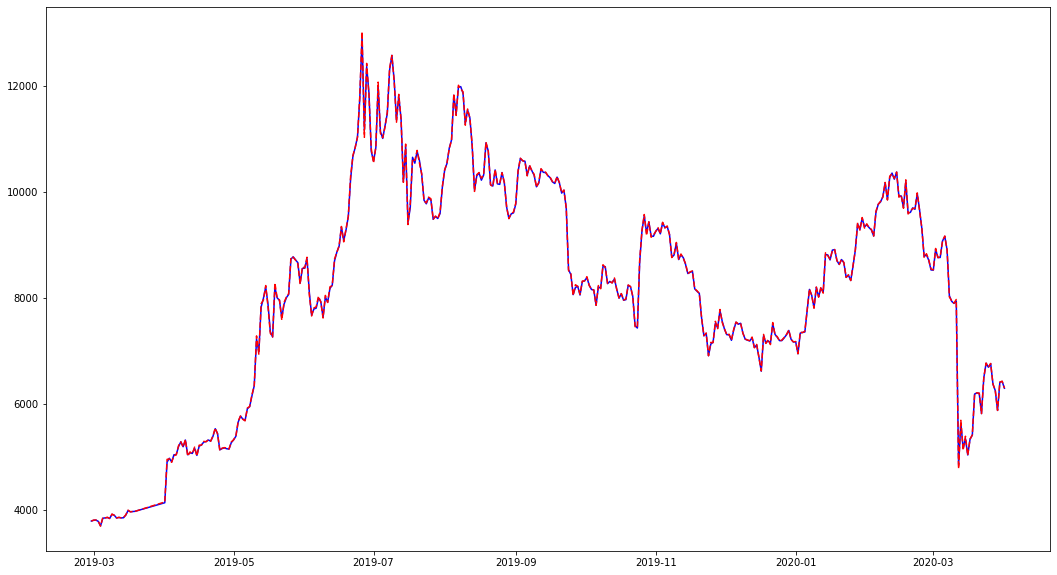

In [126]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
df = df.asfreq('D') # D or H

ar_forecast = ARForecast(df = df, 
                               percentage_train_size = 0.80)
ar_forecast.perform()

In [21]:
class MAForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        corr, _ = pearsonr(y_truth, y_forecasted)
        pearson = round(corr, 4)

#         print('mae', mae)
#         print('mape', mape)
#         print('mse', mse)
#         print('rmse', rmse)
#         print('rmspe', rmspe)
#         print('r2', r2)
#         print('pearson', pearson)
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
        
#         mod = sm.tsa.statespace.SARIMAX(self.df[:last_index],
#                                         order=(best_order[0], best_order[1], best_order[2]),
#                                         seasonal_order=(0, 0, 0, 0),
#                                         enforce_stationarity=False,
#                                         enforce_invertibility=False)
#         results = mod.fit()
#         pred = results.forecast(steps = 1)
        
        model = pm.ARIMA(order = best_order) #enforce_stationarity = False
        model = model.fit(self.df[:last_index])
        
#         model = model.update(self.df[last_index:last_index])
        
        print(self.df[last_index:last_index])
        pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        best_aic = np.inf 
        best_order = None
        best_mdl = None

        q_rng = range(6)
        d_rng = range(3) # [0,1,2]
        for d in d_rng:
            for q in q_rng:
                try:
                    mod = pm.ARIMA(order=(0, d, q))

                    results = mod.fit(self.df.iloc[:last_index])

                    tmp_aic = results.aic()
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (0, d, q)
                        best_mdl = mod #não esta sendo utilizado
                except: continue

#         model = pm.auto_arima(self.df.iloc[:-last_index],
#                               start_p = 0,
#                               start_d = 0, 
#                               start_q = 0, 
#                               max_p = 0,
#                               max_d = 2,
#                               max_q = 5,
#                               seasonal=False)

#         best_aic = model.aic()
#         best_order = model.order #não esta sendo utilizado
#         best_mdl = model
        
        
        print('aic: %6.2f | order: %s'%(best_aic, best_order))

        return best_order, last_index, best_mdl
    




aic: 1568.74 | order: (0, 2, 2)
              Close
Date               
2019-09-22  10026.8
last_index 2019-09-22 00:00:00
pred 10038.901116972986
              Close
Date               
2019-09-23  9693.74
last_index 2019-09-23 00:00:00
pred 9694.709742515694
              Close
Date               
2019-09-24  8530.01
last_index 2019-09-24 00:00:00
pred 8503.160491542238
              Close
Date               
2019-09-25  8438.35
last_index 2019-09-25 00:00:00
pred 8443.582351374402
             Close
Date              
2019-09-26  8060.0
last_index 2019-09-26 00:00:00
pred 8054.742138260657
              Close
Date               
2019-09-27  8193.99
last_index 2019-09-27 00:00:00
pred 8204.690703608943
              Close
Date               
2019-09-28  8217.47
last_index 2019-09-28 00:00:00
pred 8224.463044964114
             Close
Date              
2019-09-29  8052.4
last_index 2019-09-29 00:00:00
pred 8053.520172444063
              Close
Date               
2019-09-30  8304.96
l

              Close
Date               
2019-12-04  7198.99
last_index 2019-12-04 00:00:00
pred 7199.046891870673
              Close
Date               
2019-12-05  7393.54
last_index 2019-12-05 00:00:00
pred 7403.804220084575
              Close
Date               
2019-12-06  7540.08
last_index 2019-12-06 00:00:00
pred 7548.806940473141
              Close
Date               
2019-12-07  7502.19
last_index 2019-12-07 00:00:00
pred 7504.874341607043
             Close
Date              
2019-12-08  7520.0
last_index 2019-12-08 00:00:00
pred 7524.711240387596
              Close
Date               
2019-12-09  7337.51
last_index 2019-12-09 00:00:00
pred 7335.245717870794
              Close
Date               
2019-12-10  7219.37
last_index 2019-12-10 00:00:00
pred 7219.136128367181
              Close
Date               
2019-12-11  7201.23
last_index 2019-12-11 00:00:00
pred 7204.157830326235
              Close
Date               
2019-12-12  7185.91
last_index 2019-12-12 00:00:00


              Close
Date               
2020-02-15  9911.22
last_index 2020-02-15 00:00:00
pred 9907.135388270592
             Close
Date              
2020-02-16  9921.0
last_index 2020-02-16 00:00:00
pred 9930.004808116135
             Close
Date              
2020-02-17  9700.0
last_index 2020-02-17 00:00:00
pred 9701.990397999954
               Close
Date                
2020-02-18  10188.04
last_index 2020-02-18 00:00:00
pred 10209.835203527531
              Close
Date               
2020-02-19  9600.08
last_index 2020-02-19 00:00:00
pred 9593.44700304448
              Close
Date               
2020-02-20  9610.05
last_index 2020-02-20 00:00:00
pred 9618.367256569132
              Close
Date               
2020-02-21  9695.66
last_index 2020-02-21 00:00:00
pred 9705.596034588196
              Close
Date               
2020-02-22  9668.23
last_index 2020-02-22 00:00:00
pred 9675.35182793211
              Close
Date               
2020-02-23  9965.01
last_index 2020-02-23 00:00:00
p

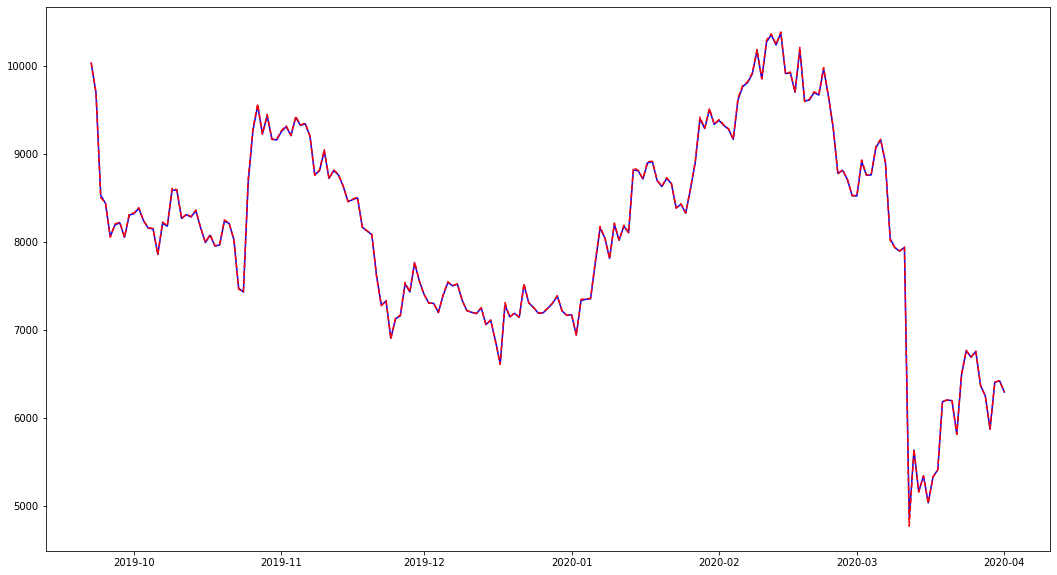

In [22]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])
df = df.asfreq('D') # D or H

ma_forecast = MAForecast(df = df, 
                               percentage_train_size = 0.90)
ma_forecast.perform()

In [8]:
# class MSARForecast(object):
    
#     def __init__(self, df, percentage_train_size):
        
#         self.df = df
#         self.percentage_train_size = percentage_train_size
    
#     def perform(self):
        
#         best_order, last_index, best_mdl = self.create_model()
        
#         array_pred = np.array([])
                
#         for row in self.df.iloc[-last_index:].itertuples():
            
#             pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
#             array_pred = np.append(array_pred, pred)
#             print('last_index', row[0])
#             print('pred', pred)
        
#         print('---')
        
#         y_true = self.df.iloc[-last_index:]['Close'].values
#         y_pred = array_pred.reshape(-1, 1)
#         print('len', len(y_true), len(y_pred)) #somente para checar
#         data = {
#             'y_true': self.df.iloc[-last_index:]['Close'].values,
#             'y_pred': array_pred
#         }
        
#         df_aux = pd.DataFrame(data)
        
#         mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
#         print('mae', mae,
#               'mape', mape,
#               'mse', mse,
#               'rmse', rmse,
#               'rmspe', rmspe,
#               'r2', r2,
#               'pearson', pearson)
        
#         fig, ax = plt.subplots(figsize=(18, 10))
#         ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
#         ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
#     def perform_metrics(self, y_truth, y_forecasted): 

#         mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
#         mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
#         mse = round(mean_squared_error(y_truth, y_forecasted), 4)
#         rmse = round(mse**(0.5), 4)
#         rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
#         r2 = round(r2_score(y_truth, y_forecasted), 4)
#         corr, _ = pearsonr(y_truth, y_forecasted)
#         pearson = round(corr, 4)

# #         print('mae', mae)
# #         print('mape', mape)
# #         print('mse', mse)
# #         print('rmse', rmse)
# #         print('rmspe', rmspe)
# #         print('r2', r2)
# #         print('pearson', pearson)
    
#         return mae, mape, mse, rmse, rmspe, r2, pearson
    
#     def prediction(self, best_order, last_index, model):
        
#         if best_order[1] == 0:
#             df_train = self.df.loc[:, ['Close']]
# #             df_train = df_train.dropna()
# #             df_train = df_train.asfreq('d')
#         if best_order[1] == 1:
#             df_train = self.df.loc[:, ['diff_1']].dropna()
# #             df_train = df_train.dropna()
# #             df_train = df_train.asfreq('d')
#         if best_order[1] == 2:
#             df_train = self.df.loc[:, ['diff_2']].dropna()
# #             df_train = df_train.dropna()
# #             df_train = df_train.asfreq('d')
    
#         start = last_index.strftime('%Y-%m-%d')
#         end = (last_index + pd.Timedelta(days = 1)).strftime('%Y-%m-%d')
#         print('start', start)
#         print('end', end)

#         df_train = df_train[:last_index]
        
#         print('last_index', last_index)
#         print("df_train pred", df_train.index)
#         print("df_train info\n", df_train.info())
#         print("df_train na sum\n", df_train.isna().sum())
        
#         mod_hamilton = sm.tsa.MarkovAutoregression(df_train, k_regimes=2, order=best_order[0], switching_ar=True)
#         res_hamilton = mod_hamilton.fit()
#         print('pass 2')
# #         df_train = df_train.reset_index(drop=True)
# #         start = df_train.index[-1]
# #         end = start + 1
# #         print('start', start)
# #         print('end', end)
#         pred = res_hamilton.predict(start = start, end = end)[-1]
        
#         print(self.df[last_index:last_index])
        
#         print('last_row.values[0]', last_row.values[0])
#         print('pred 1', pred)
#         pred = last_row.values[0] + pred
    
#         return pred, model
    
#     def create_model(self):
        
#         last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
#         best_aic = np.inf 
#         best_order = None
#         best_mdl = None

#         p_rng = range(1, 5)
#         d_rng = range(3) # [0,1,2]
        
#         for d in d_rng:
            
#             if d == 0:
#                 df_train = self.df.loc[:, ['Close']].dropna()
# #                 df_train = df_train.asfreq('d')
#             if d == 1:
#                 df_train = self.df.loc[:, ['diff_1']].dropna()
# #                 df_train = df_train.asfreq('d')
#             if d == 2:
#                 df_train = self.df.loc[:, ['diff_2']].dropna()
# #                 df_train = df_train.asfreq('d')
#             print('df_train', df_train.index)
#             for p in p_rng:
#                 try:
#                     mod = sm.tsa.MarkovAutoregression(df_train.iloc[:last_index], k_regimes=2, order=p, switching_ar=True)
#                     results = mod.fit()
#                     tmp_aic = results.aic
    
#                     if tmp_aic < best_aic:
#                         best_aic = tmp_aic
#                         best_order = (p, d)
#                         best_mdl = mod #não esta sendo utilizado
#                         print('best_order', best_order) #apagar dps
#                 except: continue        
        
#         print('aic: %6.2f | order: %s'%(best_aic, best_order))

#         return best_order, last_index, best_mdl

In [33]:
# ### MAIN

# df = df_gemini_price_d.copy()
# # df = df_gemini_price_1h.copy()

# df['Date'] = pd.to_datetime(df['Date'])
# #print('null\n', df.isnull().sum())

# df = df.set_index('Date')
# df = df.loc[:, ['Close']]
# df = df.sort_values(by = ['Date'])

# #fazendo a serie ser estacionaria 
# df['diff_1'] = df['Close'].diff()
# df['diff_2'] = df['diff_1'].diff()
# df = df.asfreq('d')

# msar_forecast = MSARForecast(df = df, 
#                              percentage_train_size = 0.98)
# msar_forecast.perform()

#NÂO POSSUI O PREDICT OUT OF SAMPLE IMPLEMENTADO

In [12]:
#fazer uma tabela com resultados 

In [47]:
class NaiveForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        last_index = self.find_valid_last_index()
        
        array_pred = np.array([])

        for row in self.df.iloc[-last_index:].itertuples():
            
            pred = self.prediction(last_index = row[0])
            array_pred = np.append(array_pred, pred)
            print('last_index->', row[0])
            print('pred->\n', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        ax.legend()
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, last_index):
        
        last_index -= pd.Timedelta(days = 1)
        pred = self.df[last_index:last_index]['Close']
        
        return pred
    
    def find_valid_last_index(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        return last_index

last_index-> 2019-05-17 00:00:00
pred->
 Date
2019-05-16    7881.38
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-18 00:00:00
pred->
 Date
2019-05-17    7361.92
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-19 00:00:00
pred->
 Date
2019-05-18    7262.52
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-20 00:00:00
pred->
 Date
2019-05-19    8192.44
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-21 00:00:00
pred->
 Date
2019-05-20    8003.97
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-22 00:00:00
pred->
 Date
2019-05-21    7954.49
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-23 00:00:00
pred->
 Date
2019-05-22    7620.0
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-24 00:00:00
pred->
 Date
2019-05-23    7879.92
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-25 00:00:00
pred->
 Date
2019-05-24    8004.36
Freq: D, Name: Close, dtype: float64
last_index-> 2019-05-26 00:00:00
pred->
 Date
2019-05-25

Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-02 00:00:00
pred->
 Date
2019-10-01    8330.62
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-03 00:00:00
pred->
 Date
2019-10-02    8384.51
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-04 00:00:00
pred->
 Date
2019-10-03    8206.45
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-05 00:00:00
pred->
 Date
2019-10-04    8157.3
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-06 00:00:00
pred->
 Date
2019-10-05    8150.97
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-07 00:00:00
pred->
 Date
2019-10-06    7860.01
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-08 00:00:00
pred->
 Date
2019-10-07    8208.67
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-09 00:00:00
pred->
 Date
2019-10-08    8188.17
Freq: D, Name: Close, dtype: float64
last_index-> 2019-10-10 00:00:00
pred->
 Date
2019-10-09    8592.01
Freq: D, Name: Close, dtype: float64
last_index-> 2019-1

last_index-> 2020-03-04 00:00:00
pred->
 Date
2020-03-03    8751.88
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-05 00:00:00
pred->
 Date
2020-03-04    8757.05
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-06 00:00:00
pred->
 Date
2020-03-05    9067.35
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-07 00:00:00
pred->
 Date
2020-03-06    9158.02
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-08 00:00:00
pred->
 Date
2020-03-07    8902.65
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-09 00:00:00
pred->
 Date
2020-03-08    8038.84
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-10 00:00:00
pred->
 Date
2020-03-09    7932.95
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-11 00:00:00
pred->
 Date
2020-03-10    7881.02
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-12 00:00:00
pred->
 Date
2020-03-11    7935.49
Freq: D, Name: Close, dtype: float64
last_index-> 2020-03-13 00:00:00
pred->
 Date
2020-03-1

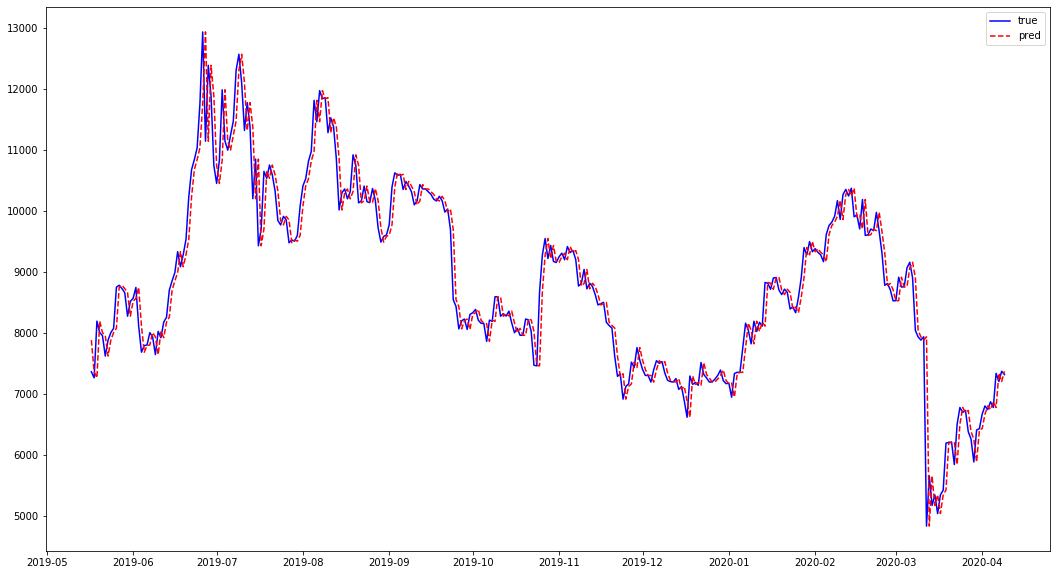

In [49]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])

# #fazendo a serie ser estacionaria 
# df['diff_1'] = df['Close'].diff()
# df['diff_2'] = df['diff_1'].diff()
df = df.asfreq('d')

naive_forecast = NaiveForecast(df = df, 
                             percentage_train_size = 0.80)

naive_forecast.perform()

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

Using TensorFlow backend.


In [72]:
df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

# df = df.set_index('Date')
df = df.sort_values(by = ['Date'])
df = df.loc[:, ['Close']]

In [73]:
prediction_days = 250

df_train= df[:len(df)-prediction_days]
df_test= df[len(df)-prediction_days:]

In [74]:
training_set = df_train.values
training_set = min_max_scaler.fit_transform(training_set)

x_train = training_set[0:len(training_set)-1]
print('x_train 0', x_train[:10])
y_train = training_set[1:len(training_set)]
print('y_train 0', y_train[:10])
x_train = np.reshape(x_train, (len(x_train), 1, 1))
print('x_train 1', x_train[:10])

x_train 0 [[0.00000000e+00]
 [7.47817308e-05]
 [1.22039630e-04]
 [2.88221254e-04]
 [1.89550915e-04]
 [3.14187133e-04]
 [4.69982406e-04]
 [5.87348178e-04]
 [1.02824880e-03]
 [1.48109372e-03]]
y_train 0 [[7.47817308e-05]
 [1.22039630e-04]
 [2.88221254e-04]
 [1.89550915e-04]
 [3.14187133e-04]
 [4.69982406e-04]
 [5.87348178e-04]
 [1.02824880e-03]
 [1.48109372e-03]
 [1.27284738e-03]]
x_train 1 [[[0.00000000e+00]]

 [[7.47817308e-05]]

 [[1.22039630e-04]]

 [[2.88221254e-04]]

 [[1.89550915e-04]]

 [[3.14187133e-04]]

 [[4.69982406e-04]]

 [[5.87348178e-04]]

 [[1.02824880e-03]]

 [[1.48109372e-03]]]


In [75]:
num_units = 4
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 5
num_epochs = 20 #100

# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = optimizer, loss = loss_function)

# Using the training set to train the model
regressor.fit(x_train, y_train, batch_size = batch_size, epochs = num_epochs)

Epoch 1/20
1395/1395 [==============================] - 4s 3ms/step - loss: 0.0451
Epoch 2/20
1395/1395 [==============================] - 2s 1ms/step - loss: 0.0351
Epoch 3/20
1395/1395 [==============================] - 2s 1ms/step - loss: 0.0294
Epoch 4/20
1395/1395 [==============================] - 2s 1ms/step - loss: 0.0235
Epoch 5/20
1395/1395 [==============================] - 2s 1ms/step - loss: 0.0177
Epoch 6/20
1395/1395 [==============================] - 2s 1ms/step - loss: 0.0123
Epoch 7/20
1395/1395 [==============================] - 2s 1ms/step - loss: 0.0077
Epoch 8/20
1395/1395 [==============================] - 1s 806us/step - loss: 0.0043
Epoch 9/20
1395/1395 [==============================] - 1s 946us/step - loss: 0.0022
Epoch 10/20
1395/1395 [==============================] - 1s 1ms/step - loss: 0.0010
Epoch 11/20
1395/1395 [==============================] - 1s 1ms/step - loss: 5.4187e-04
Epoch 12/20
1395/1395 [==============================] - 1s 1ms/step - loss: 

In [76]:
test_set = df_test.values

inputs = np.reshape(test_set, (len(test_set), 1))
inputs = min_max_scaler.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))

predicted_price = regressor.predict(inputs)
predicted_price = min_max_scaler.inverse_transform(predicted_price)

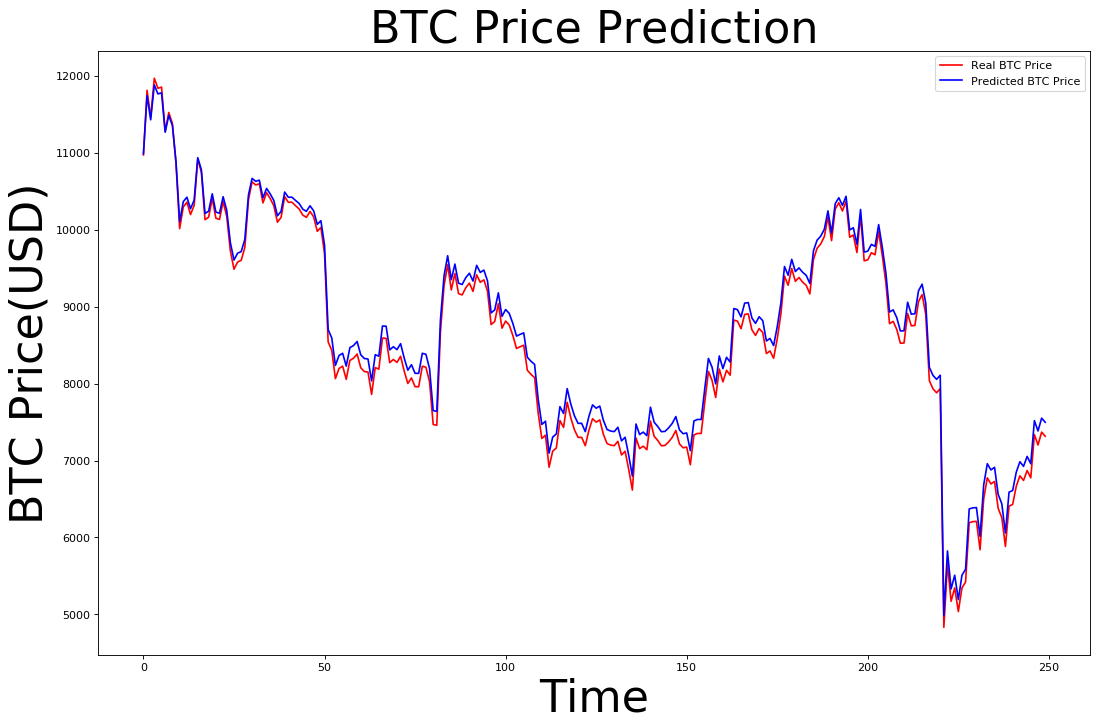

In [77]:
plt.figure(figsize=(16, 10), dpi=80, facecolor = 'w', edgecolor = 'k')

plt.plot(test_set[:, 0], color='red', label='Real BTC Price')
plt.plot(predicted_price[:, 0], color = 'blue', label = 'Predicted BTC Price')

plt.title('BTC Price Prediction', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize = 40)
plt.legend(loc = 'best')
plt.show()

In [ ]:
class LSTMForecast(object):
    
    def __init__(self, df, percentage_train_size):
        
        self.df = df
        self.percentage_train_size = percentage_train_size
    
    def perform(self):
        
        best_order, last_index, best_mdl = self.create_model()
        
        array_pred = np.array([])
                
        for row in self.df.iloc[-last_index:].itertuples():
            
            pred, best_mdl = self.prediction(best_order = best_order, last_index = row[0], model = best_mdl)
            array_pred = np.append(array_pred, pred)
            print('last_index', row[0])
            print('pred', pred)
        
        print('---')
        
        y_true = self.df.iloc[-last_index:]['Close'].values
        y_pred = array_pred.reshape(-1, 1)
        print('len', len(y_true), len(y_pred)) #somente para checar
        data = {
            'y_true': self.df.iloc[-last_index:]['Close'].values,
            'y_pred': array_pred
        }
        
        df_aux = pd.DataFrame(data)
        
        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(df_aux['y_true'], df_aux['y_pred'])
        print('mae', mae,
              'mape', mape,
              'mse', mse,
              'rmse', rmse,
              'rmspe', rmspe,
              'r2', r2,
              'pearson', pearson)
        
        fig, ax = plt.subplots(figsize=(18, 10))
        ax.plot(self.df.iloc[-last_index:].index, y_true, color="b", label = "true")
        ax.plot(self.df.iloc[-last_index:].index, y_pred, color="r", linestyle = '--', label = "pred")
        
    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None
    
        return mae, mape, mse, rmse, rmspe, r2, pearson
    
    def prediction(self, best_order, last_index, model):
                
#         model = pm.ARIMA(order = best_order)
#         model = model.fit(self.df[:last_index])
        
#         model = model.update(self.df[last_index:last_index])
        
#         print(self.df[last_index:last_index])
#         pred = model.predict(n_periods = 1, alpha = 0.05)[-1]
            
        return pred, model
    
    def create_model(self):
        
        last_index = int(len(self.df)*(1 - self.percentage_train_size))
        
        training_set = self.df.iloc[:last_index].values
        training_set = min_max_scaler.fit_transform(training_set)

        x_train = training_set[0:len(training_set)-1]
        y_train = training_set[1:len(training_set)]
        x_train = np.reshape(x_train, (len(x_train), 1, 1))
        
        best_order = {
            "num_units": 4,
            "activation_function": 'sigmoid',
            "optimizer": 'adam',
            "loss_function": 'mean_squared_error',
            "batch_size": 5,
            "num_epochs": 20
        }

        # Initialize the RNN
        regressor = Sequential()

        # Adding the input layer and the LSTM layer
        regressor.add(LSTM(units = best_order["num_units"], activation = best_order["activation_function"], input_shape=(None, 1)))

        # Adding the output layer
        regressor.add(Dense(units = 1))

        # Compiling the RNN
        regressor.compile(optimizer = best_order["optimizer"], loss = best_order["loss_function"])

        # Using the training set to train the model
        regressor.fit(x_train, y_train, batch_size = best_order["batch_size"], epochs = best_order["num_epochs"])
                
        return best_order, last_index, regressor

In [ ]:
### MAIN

df = df_gemini_price_d.copy()
# df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])
#print('null\n', df.isnull().sum())

df = df.set_index('Date')
df = df.loc[:, ['Close']]
df = df.sort_values(by = ['Date'])

# #fazendo a serie ser estacionaria 
# df['diff_1'] = df['Close'].diff()
# df['diff_2'] = df['diff_1'].diff()
df = df.asfreq('d')

lstm_forecast = LSTMForecast(df = df, 
                             percentage_train_size = 0.80)

lstm_forecast.perform()